### Learning Rate

#### 1.为什么需要调度  
- 学习率过高：模型会梯度爆炸/不收敛 
- 学习率过低：模型会收敛很慢

1. 预热：在训练开始的前几百货几千步，学习率从0线性增加到设定的最大值
2. 衰减：学习率在预热期后按照一定策略衰减
   - 余弦衰减：让学习率按照余弦曲线平滑下降到接近0的位置
   - 指数衰减：让学习率按照指数曲线平滑下降到接近0的位置

#### 2.WSD调度器
- Warm-up:快速热身
- Stable：学习率保持恒定最大值
- Decay：在训练最后10-20%的之间里，学习率迅速调到最小值

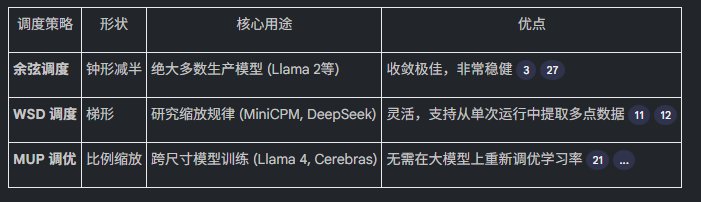

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


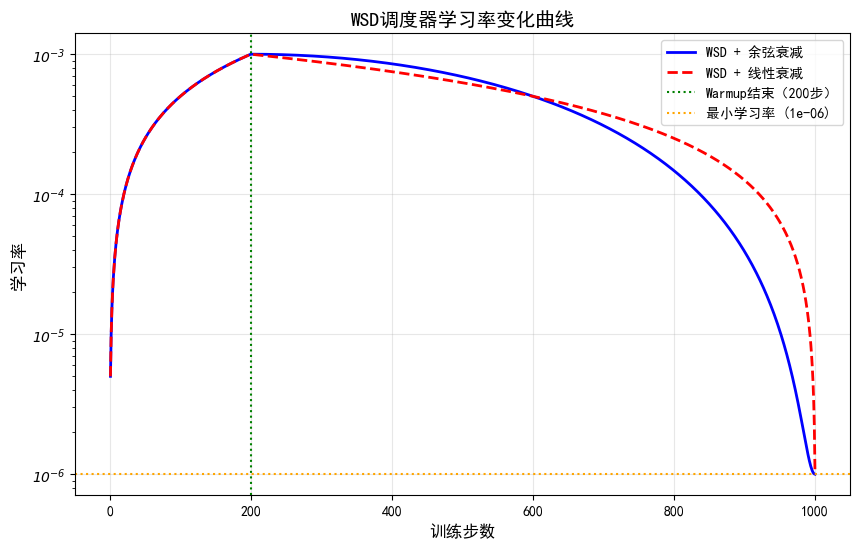

=== WSD调度器关键信息 ===
基础学习率: 0.001
Warmup步数: 200, 总步数: 1000
余弦衰减 - Warmup结束学习率: 0.001000, 最终学习率: 0.000001
线性衰减 - Warmup结束学习率: 0.001000, 最终学习率: 0.000001
Epoch [1/10], 平均损失: 2.3169, 最后一步学习率: 0.000500
Epoch [2/10], 平均损失: 2.3166, 最后一步学习率: 0.000485
Epoch [3/10], 平均损失: 2.3155, 最后一步学习率: 0.000442
Epoch [4/10], 平均损失: 2.3117, 最后一步学习率: 0.000375
Epoch [5/10], 平均损失: 2.3123, 最后一步学习率: 0.000294
Epoch [6/10], 平均损失: 2.3085, 最后一步学习率: 0.000207
Epoch [7/10], 平均损失: 2.3144, 最后一步学习率: 0.000126
Epoch [8/10], 平均损失: 2.3116, 最后一步学习率: 0.000059
Epoch [9/10], 平均损失: 2.3078, 最后一步学习率: 0.000016
Epoch [10/10], 平均损失: 2.3100, 最后一步学习率: 0.000001


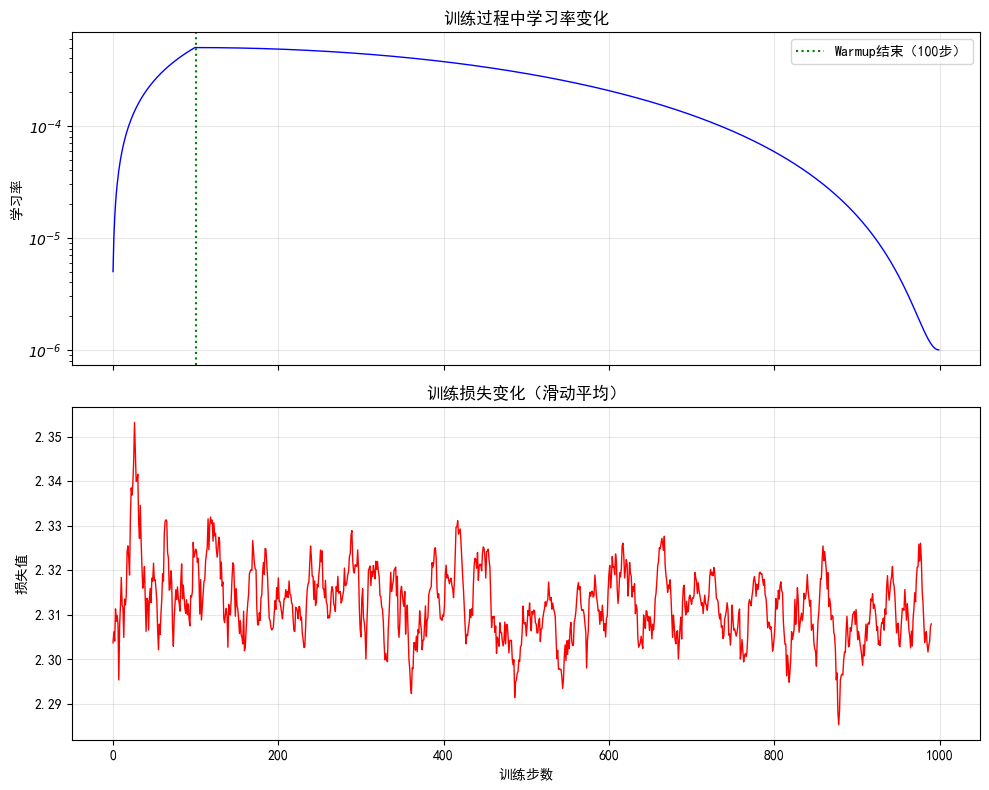

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

class WSDScheduler:
    """
    WSD (Warmup + Scheduler Decay) 学习率调度器
    核心逻辑：
    1. Warmup阶段：前warmup_steps步，学习率从0线性提升到基础学习率
    2. Decay阶段：warmup结束后，按指定策略（余弦/线性）衰减学习率
    """
    def __init__(self, optimizer, warmup_steps, total_steps, lr_scheduler_type="cosine", min_lr=1e-6):
        """
        参数说明：
            optimizer: 待调度的优化器（如AdamW）
            warmup_steps: warmup阶段的总步数
            total_steps: 训练的总步数（warmup + decay）
            lr_scheduler_type: 衰减策略，可选 "cosine"（余弦退火）或 "linear"（线性衰减）
            min_lr: 衰减阶段的最小学习率（防止学习率降为0）
        """
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.lr_scheduler_type = lr_scheduler_type
        self.min_lr = min_lr
        
        # 记录初始学习率（优化器中所有参数组的基础学习率）
        self.base_lrs = [param_group['lr'] for param_group in optimizer.param_groups]
        self.current_step = 0  # 当前训练步数

    def step(self):
        """执行一步学习率更新"""
        self.current_step += 1
        lr = self._get_lr()
        
        # 更新优化器所有参数组的学习率
        for i, param_group in enumerate(self.optimizer.param_groups):
            param_group['lr'] = lr * (self.base_lrs[i] / self.base_lrs[0])  # 适配多参数组
        
        return lr

    def _get_lr(self):
        """计算当前步数对应的学习率"""
        step = self.current_step
        
        # 1. Warmup阶段：线性提升学习率
        if step <= self.warmup_steps:
            # 学习率从0线性增加到base_lr
            lr = self.base_lrs[0] * (step / self.warmup_steps)
        # 2. Decay阶段：按指定策略衰减
        else:
            # 计算衰减阶段的相对步数（0 ~ 1）
            decay_step = step - self.warmup_steps
            decay_total_steps = self.total_steps - self.warmup_steps
            decay_ratio = decay_step / decay_total_steps
            
            if self.lr_scheduler_type == "cosine":
                # 余弦退火衰减：lr = min_lr + 0.5*(base_lr - min_lr)*(1 + cos(π*decay_ratio))
                lr = self.min_lr + 0.5 * (self.base_lrs[0] - self.min_lr) * (1 + np.cos(np.pi * decay_ratio))
            elif self.lr_scheduler_type == "linear":
                # 线性衰减：lr = base_lr*(1 - decay_ratio) + min_lr*decay_ratio
                lr = self.base_lrs[0] * (1 - decay_ratio) + self.min_lr * decay_ratio
            else:
                raise ValueError(f"不支持的衰减策略: {self.lr_scheduler_type}")
        
        return lr

    def get_current_lr(self):
        """获取当前学习率"""
        return self.optimizer.param_groups[0]['lr']

# ===================== 测试案例：可视化WSD调度器的学习率变化 =====================
def test_wsd_scheduler():
    # 模拟简单模型和优化器
    model = nn.Linear(10, 1)  # 简单线性模型
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    
    # 定义WSD调度器参数
    total_train_steps = 1000  # 总训练步数
    warmup_steps = 200        # Warmup步数（前20%）
    min_lr = 1e-6             # 最小学习率
    
    # 初始化两种衰减策略的WSD调度器
    scheduler_cosine = WSDScheduler(
        optimizer=optimizer,
        warmup_steps=warmup_steps,
        total_steps=total_train_steps,
        lr_scheduler_type="cosine",
        min_lr=min_lr
    )
    
    scheduler_linear = WSDScheduler(
        optimizer=optimizer,
        warmup_steps=warmup_steps,
        total_steps=total_train_steps,
        lr_scheduler_type="linear",
        min_lr=min_lr
    )
    
    # 模拟训练过程，记录学习率变化
    lr_history_cosine = []
    lr_history_linear = []
    steps = list(range(1, total_train_steps + 1))
    
    # 记录余弦衰减的学习率
    for _ in steps:
        lr = scheduler_cosine.step()
        lr_history_cosine.append(lr)
    
    # 重置优化器学习率，记录线性衰减的学习率
    for param_group in optimizer.param_groups:
        param_group['lr'] = 1e-3
    scheduler_linear.current_step = 0  # 重置步数
    for _ in steps:
        lr = scheduler_linear.step()
        lr_history_linear.append(lr)
    
    # 可视化学习率变化曲线
    plt.figure(figsize=(10, 6))
    
    # 绘制余弦衰减曲线
    plt.plot(steps, lr_history_cosine, label='WSD + 余弦衰减', color='blue', linewidth=2)
    # 绘制线性衰减曲线
    plt.plot(steps, lr_history_linear, label='WSD + 线性衰减', color='red', linestyle='--', linewidth=2)
    
    # 标记warmup阶段
    plt.axvline(x=warmup_steps, color='green', linestyle=':', label=f'Warmup结束（{warmup_steps}步）')
    plt.axhline(y=min_lr, color='orange', linestyle=':', label=f'最小学习率 ({min_lr})')
    
    # 图表美化
    plt.title('WSD调度器学习率变化曲线', fontsize=14)
    plt.xlabel('训练步数', fontsize=12)
    plt.ylabel('学习率', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # 对数刻度，更清晰展示学习率变化
    
    # 保存并显示图表
    plt.savefig('wsd_scheduler_lr_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印关键信息
    print("=== WSD调度器关键信息 ===")
    print(f"基础学习率: {1e-3}")
    print(f"Warmup步数: {warmup_steps}, 总步数: {total_train_steps}")
    print(f"余弦衰减 - Warmup结束学习率: {lr_history_cosine[warmup_steps-1]:.6f}, 最终学习率: {lr_history_cosine[-1]:.6f}")
    print(f"线性衰减 - Warmup结束学习率: {lr_history_linear[warmup_steps-1]:.6f}, 最终学习率: {lr_history_linear[-1]:.6f}")

# ===================== 实际训练中使用WSD调度器的示例 =====================
def train_with_wsd():
    """模拟完整训练流程中使用WSD调度器"""
    # 1. 初始化模型、优化器、损失函数
    model = nn.Sequential(
        nn.Linear(20, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.005)
    criterion = nn.CrossEntropyLoss()
    
    # 2. 计算总训练步数（假设训练10个epoch，每个epoch 100步）
    epochs = 10
    steps_per_epoch = 100
    total_steps = epochs * steps_per_epoch
    warmup_steps = int(total_steps * 0.1)  # Warmup占总步数的10%
    
    # 3. 初始化WSD调度器（余弦衰减）
    scheduler = WSDScheduler(
        optimizer=optimizer,
        warmup_steps=warmup_steps,
        total_steps=total_steps,
        lr_scheduler_type="cosine",
        min_lr=1e-6
    )
    
    # 4. 模拟训练循环
    lr_history = []
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for step in range(steps_per_epoch):
            # 模拟输入数据和标签
            x = torch.randn(32, 20)  # batch_size=32
            y = torch.randint(0, 10, (32,))
            
            # 前向传播
            outputs = model(x)
            loss = criterion(outputs, y)
            
            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 更新学习率（关键：每步都要调用scheduler.step()）
            current_lr = scheduler.step()
            
            # 记录数据
            epoch_loss += loss.item()
            lr_history.append(current_lr)
            loss_history.append(loss.item())
        
        # 打印epoch信息
        avg_loss = epoch_loss / steps_per_epoch
        print(f"Epoch [{epoch+1}/{epochs}], 平均损失: {avg_loss:.4f}, 最后一步学习率: {current_lr:.6f}")
    
    # 可视化训练过程的学习率和损失
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # 学习率曲线
    ax1.plot(lr_history, color='blue', linewidth=1)
    ax1.axvline(x=warmup_steps, color='green', linestyle=':', label=f'Warmup结束（{warmup_steps}步）')
    ax1.set_title('训练过程中学习率变化')
    ax1.set_ylabel('学习率')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 损失曲线（平滑处理）
    loss_smooth = np.convolve(loss_history, np.ones(10)/10, mode='valid')  # 滑动平均平滑
    ax2.plot(range(len(loss_smooth)), loss_smooth, color='red', linewidth=1)
    ax2.set_title('训练损失变化（滑动平均）')
    ax2.set_xlabel('训练步数')
    ax2.set_ylabel('损失值')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    test_wsd_scheduler()
  
    train_with_wsd()